# Modeling Polio Infections and Deaths with Hypothetical Vaccination Dates

Project 1 

Katie B. & Michael R.


In [248]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# import read_csv to import data
from pandas import read_csv

In [249]:
# Load our data as a table
filename = '../../Project 1/Polio Data.csv'
table = read_csv(filename, header=0, index_col=0, decimal='.')
len(table)
table.columns = ['polios', 'census']
# Show the first five rows of the imported data
table.head()

,polios,census
Year,,
1910,3043,92000000
1911,0,93343578
1912,574,94706778
1913,0,96089886
1914,0,97493193


In [250]:
def plot_results(series1, series2, title, x_label, y_label):
    """Plot two timeseries.
    
    series1: First timeSeries to plot
    series2: Second timeSeries to plot
    title: string
    """
    if len(series1):
        plot(series1, ':', label='Series 1')
    if len(series2):
        plot(series2, color='gray', label='Series 2')
    
    decorate(xlabel=x_label, 
             ylabel=y_label,
             title=title)

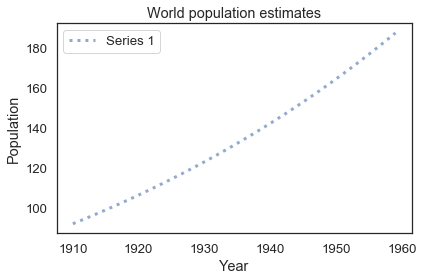

In [251]:
empty = TimeSeries()
census = table.census / 1e6

plot_results(census, empty, 'World population estimates', 'Year','Population')

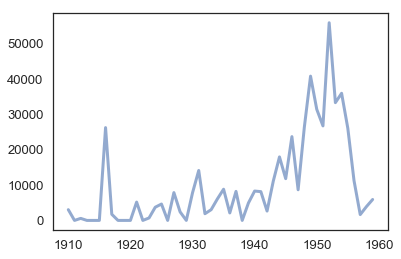

In [252]:
plot(table.polios)

In [264]:
# Define initial conditions for all systems
# Start year
t_0 = get_first_label(census)
# End year
t_end = get_last_label(census)
# Initial Population
p_tot_0 = get_first_value(census)
# Init state containing the above, assuming no polio infections or deaths yet
init = State(p_infected=0, p_tot=p_tot_0,p_dead_polios=0,p_polio_cases=0)

,values
p_infected,0.0
p_tot,92.0
p_dead_polios,0.0
p_polio_cases,0.0


In [263]:
system = System(polio_growth = 10286,
                t_0 = t_0,
                t_end = t_end,
                p_tot_0 = p_tot_0,
                p_infected_0 = 0,
                p_dead_polios = 0,
                init=init)

,values
polio_growth,10286
t_0,1910
t_end,1959
p_tot_0,92
p_infected_0,0
p_dead_polios,0
init,p_infected 58442.427684 p_tot ...


# Linear Growth
To begin, we assume the rate at which polio spreads is a constant 10,286 cases per year and that 15% die, leaving 85% remaining.
The control data, which does not account for deaths, is also summed here


In [255]:
def update_func1(state, t, system):
    """Update function for constant infection rate. 
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    state.p_tot = census[t+1]
    state.p_infected += system.polio_growth
    state.p_polio_cases += table.polios[t]
    #state.p_dead_polios += state.p_infected * 0.15
    #state.p_infected *= 0.85
    return State(p_infected=state.p_infected,p_polio_cases=state.p_polio_cases)

We use run simulation to simulate each year as it passes, recording the number of infected as we go and giving the output as a DataFrame object

In [256]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = DataFrame()
    results.index.write = table.index
    state = system.init
    results[system.t_0] = State(p_infected=0,p_polio_cases=0)
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(state, t, system)
        
    return results

In [257]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func1).T;

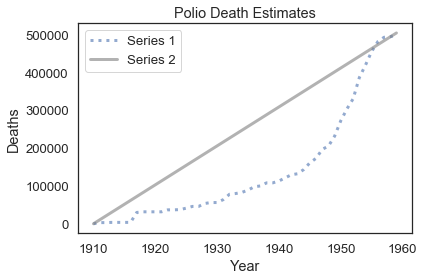

In [258]:
# Plot the results
plot_results(results.p_polio_cases, results.p_infected, 'Polio Death Estimates','Year','Deaths')

Here, the linear model starts and ends in the same place, but it does not line up well anywhere else.
Also, neither of these plots account for the death rate of the disease, so we need a new update function that does account for this. 

# Accounting for death

Below is our new update function which is the same to the first, except that now we account for deaths by assuming 15% of the infected die every year for both the linear model and real world data.

In [267]:
def update_func2(state, t, system):
    """Update function for constant infection rate, but accounting for deaths 
    
    state: state object
    t: year
    system: system object
        
    returns: state object
    """
    state.p_tot = census[t+1]
    
    # Add this year's cases to the running total, then account for deaths
    state.p_polio_cases += table.polios[t]
    state.p_polio_cases *= 0.85
    
    # Calculate the spread of polio, the resulting deaths, and who is left
    state.p_infected += system.polio_growth
    state.p_dead_polios += state.p_infected * 0.15
    state.p_infected *= 0.85
    
    return State(p_infected=state.p_infected,p_polio_cases=state.p_polio_cases)

In [271]:
# Init state containing the above, assuming no polio infections or deaths yet
init = State(p_infected=0, p_tot=p_tot_0,p_dead_polios=0,p_polio_cases=0)
system = System(polio_growth = 10286,
                t_0 = t_0,
                t_end = t_end,
                p_tot_0 = p_tot_0,
                p_infected_0 = 0,
                p_dead_polios = 0,
                init=init)

,values
polio_growth,10286
t_0,1910
t_end,1959
p_tot_0,92
p_infected_0,0
p_dead_polios,0
init,p_infected 0.0 p_tot 92.0 p_...


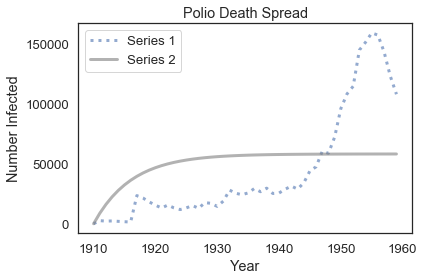

In [272]:
# Run the simulation (transpose the results so the index is first column, not first row)
results = run_simulation(system, update_func2).T
# Plot the results
plot_results(results.p_polio_cases, results.p_infected, 'Polio Death Spread','Year','Number Infected')

Now, the linear spread model seems to have become worse than before, even though both were subjected to the same death rate.

# Proportional Growth